In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
np.random.seed(0)

In [3]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [4]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

0

### Visualization of the covariance matrix:

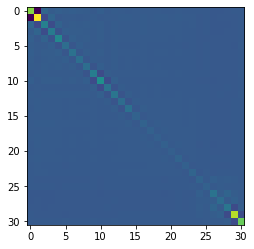

In [5]:
plt.imshow(syscov)

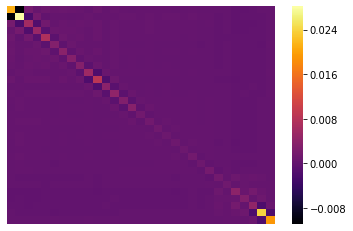

In [6]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
plt.savefig("original_cov_binned_JLA.png", dpi=200)

In [7]:
np.min(np.abs(syscov)), np.max(np.abs(syscov)) #checking non-negatives in the diagonal

(1.695011341e-07, 0.02815552265)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [8]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.001 * err
#     covset_noise[i] = syscov + 0.001*err

 Generating 620 matrix 

 Generating 1000 matrix 

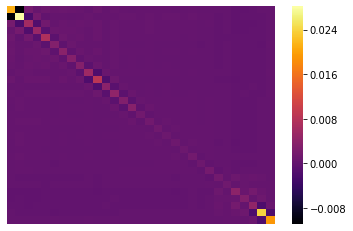

In [9]:
val, vec = np.linalg.eigh(syscov)
D = np.diag(val)
new = (vec+0.1) @ (D) @ (vec+0.1).T
sns.heatmap(pd.DataFrame(syscov), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

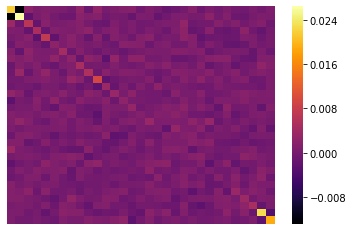

In [10]:
sns.heatmap(pd.DataFrame(covset[10]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [11]:
print(np.shape(covset))

(1000, 31, 31)


(1000, 31, 31)


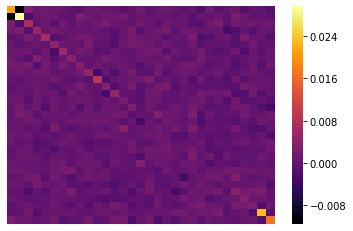

In [12]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [13]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(100, activation='tanh')(input_img)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)
x = layers.Dropout(0.2)(encoded)
#begin decoder
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
decoded = layers.Dense(31*31, activation='linear')(x)


# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3131      
_________________________________________________________________
dropout_2 (Dropout)          (None, 31)               

In [14]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))

In [15]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=100, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(covset_noise_test, covset_test))
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/500
25/25 [==============================] - 0s 16ms/step - loss: 3.6844e-06 - val_loss: 1.4431e-06
Epoch 2/500
25/25 [==============================] - 0s 4ms/step - loss: 2.0467e-06 - val_loss: 1.3559e-06
Epoch 3/500
25/25 [==============================] - 0s 4ms/step - loss: 1.8762e-06 - val_loss: 1.3131e-06
Epoch 4/500
25/25 [==============================] - 0s 4ms/step - loss: 1.8429e-06 - val_loss: 1.4334e-06
Epoch 5/500
25/25 [==============================] - 0s 4ms/step - loss: 1.8429e-06 - val_loss: 1.3603e-06
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 1.8028e-06 - val_loss: 1.3259e-06
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 1.7595e-06 - val_loss: 1.3084e-06
Epoch 8/500
25/25 [==============================] - 0s 4ms/step - loss: 1.7077e-06 - val_loss: 1.2593e-06
Epoch 9/500
25/25 [==============================] - 0s 5ms/step - loss: 1.7116e-06 - val_loss: 1.2686e-06
Epoch 10/500
25/25 [================

Epoch 77/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1404e-06 - val_loss: 1.0793e-06
Epoch 78/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1389e-06 - val_loss: 1.0681e-06
Epoch 79/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1355e-06 - val_loss: 1.0775e-06
Epoch 80/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1392e-06 - val_loss: 1.0739e-06
Epoch 81/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1354e-06 - val_loss: 1.0809e-06
Epoch 82/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1387e-06 - val_loss: 1.0810e-06
Epoch 83/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1394e-06 - val_loss: 1.0772e-06
Epoch 84/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1300e-06 - val_loss: 1.0701e-06
Epoch 85/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1297e-06 - val_loss: 1.0730e-06
Epoch 86/500
25/25 [========

25/25 [==============================] - 0s 4ms/step - loss: 1.1017e-06 - val_loss: 1.0654e-06
Epoch 153/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0989e-06 - val_loss: 1.0741e-06
Epoch 154/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1025e-06 - val_loss: 1.0664e-06
Epoch 155/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0954e-06 - val_loss: 1.0634e-06
Epoch 156/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0980e-06 - val_loss: 1.0804e-06
Epoch 157/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1015e-06 - val_loss: 1.0752e-06
Epoch 158/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0966e-06 - val_loss: 1.0671e-06
Epoch 159/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0979e-06 - val_loss: 1.0707e-06
Epoch 160/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1006e-06 - val_loss: 1.0736e-06
Epoch 161/500
25/25 [============

25/25 [==============================] - 0s 5ms/step - loss: 1.0898e-06 - val_loss: 1.0686e-06
Epoch 228/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0830e-06 - val_loss: 1.0630e-06
Epoch 229/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0807e-06 - val_loss: 1.0713e-06
Epoch 230/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0852e-06 - val_loss: 1.0649e-06
Epoch 231/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0830e-06 - val_loss: 1.0657e-06
Epoch 232/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0854e-06 - val_loss: 1.0655e-06
Epoch 233/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0824e-06 - val_loss: 1.0713e-06
Epoch 234/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0843e-06 - val_loss: 1.0572e-06
Epoch 235/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0811e-06 - val_loss: 1.0633e-06
Epoch 236/500
25/25 [============

25/25 [==============================] - 0s 6ms/step - loss: 1.0785e-06 - val_loss: 1.0582e-06
Epoch 303/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0820e-06 - val_loss: 1.0630e-06
Epoch 304/500
25/25 [==============================] - 0s 7ms/step - loss: 1.0781e-06 - val_loss: 1.0673e-06
Epoch 305/500
25/25 [==============================] - 0s 6ms/step - loss: 1.0802e-06 - val_loss: 1.0647e-06
Epoch 306/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0720e-06 - val_loss: 1.0579e-06
Epoch 307/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0778e-06 - val_loss: 1.0707e-06
Epoch 308/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0762e-06 - val_loss: 1.0621e-06
Epoch 309/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0761e-06 - val_loss: 1.0684e-06
Epoch 310/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0764e-06 - val_loss: 1.0623e-06
Epoch 311/500
25/25 [============

25/25 [==============================] - 0s 5ms/step - loss: 1.0730e-06 - val_loss: 1.0636e-06
Epoch 378/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0735e-06 - val_loss: 1.0599e-06
Epoch 379/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0726e-06 - val_loss: 1.0620e-06
Epoch 380/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0742e-06 - val_loss: 1.0678e-06
Epoch 381/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0745e-06 - val_loss: 1.0717e-06
Epoch 382/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0733e-06 - val_loss: 1.0573e-06
Epoch 383/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0713e-06 - val_loss: 1.0600e-06
Epoch 384/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0734e-06 - val_loss: 1.0686e-06
Epoch 385/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0744e-06 - val_loss: 1.0612e-06
Epoch 386/500
25/25 [============

25/25 [==============================] - 0s 5ms/step - loss: 1.0707e-06 - val_loss: 1.0549e-06
Epoch 453/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0674e-06 - val_loss: 1.0660e-06
Epoch 454/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0736e-06 - val_loss: 1.0626e-06
Epoch 455/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0724e-06 - val_loss: 1.0572e-06
Epoch 456/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0702e-06 - val_loss: 1.0608e-06
Epoch 457/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0719e-06 - val_loss: 1.0599e-06
Epoch 458/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0713e-06 - val_loss: 1.0610e-06
Epoch 459/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0709e-06 - val_loss: 1.0650e-06
Epoch 460/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0737e-06 - val_loss: 1.0685e-06
Epoch 461/500
25/25 [============

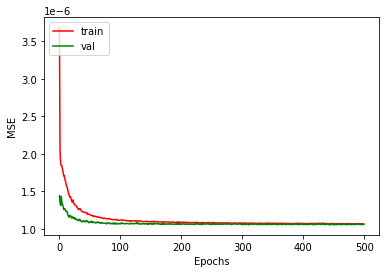

In [16]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLA.png', dpi=200)

In [17]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

1.0548260434006809e-06 1.0641934977684286e-06


In [18]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
# np.min(encoded_imgs)

(200, 31)


(200, 961)


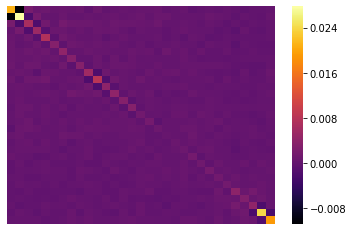

In [19]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")

In [20]:
print(np.shape(decoded_imgs))

(200, 961)


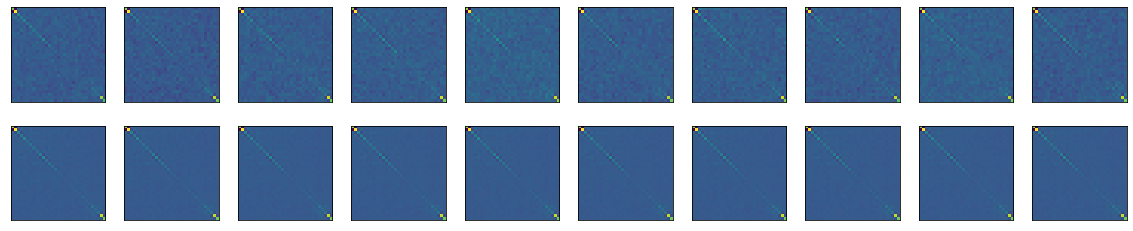

In [21]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(covset_test[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

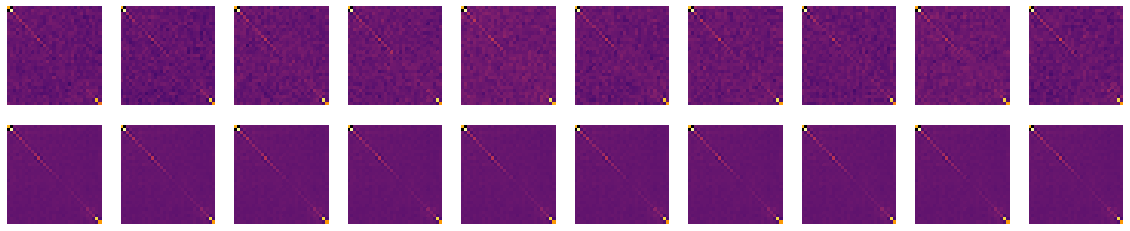

In [22]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we train another neural network for z and $D_L(z)$

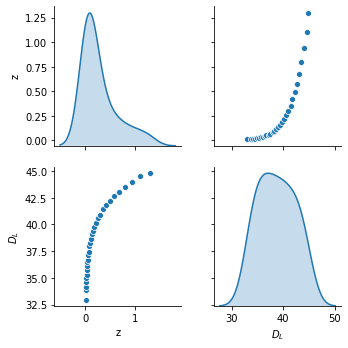

In [23]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
# print(data.head(31))
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistbinnedJLA.png")

In [24]:
shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]

In [25]:
z = data[:,0]
dl = data[:,1:]

In [26]:
# scalerz = StandardScaler()
# # scalerz = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scalerz.fit(z.reshape(-1,1))
# # apply transform
# z = scalerz.transform(z.reshape(-1,1))

In [27]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1, 1))
zz = scalerz.transform(z.reshape((-1,1)))
z_train, z_test = np.split(zz, indx)
dl_train, dl_test = np.split(dl, indx)

In [28]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(50, activation='relu')(efirst)
    x = Dense(50, activation='relu')(x)
    x = Dense(30, activation='relu')(x)

    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 31        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
____________________________________________________

In [29]:
model_train = neural_model.fit(z_train, dl_train, batch_size=2,
                                    epochs=300,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/300
12/12 [==============================] - 0s 15ms/step - loss: 1440.8065 - val_loss: 1740.9895
Epoch 2/300
12/12 [==============================] - 0s 4ms/step - loss: 1424.6315 - val_loss: 1724.8381
Epoch 3/300
12/12 [==============================] - 0s 4ms/step - loss: 1397.7687 - val_loss: 1696.4824
Epoch 4/300
12/12 [==============================] - 0s 5ms/step - loss: 1347.5194 - val_loss: 1641.0166
Epoch 5/300
12/12 [==============================] - 0s 4ms/step - loss: 1242.5175 - val_loss: 1513.6290
Epoch 6/300
12/12 [==============================] - 0s 4ms/step - loss: 1033.4910 - val_loss: 1267.7965
Epoch 7/300
12/12 [==============================] - 0s 3ms/step - loss: 688.0616 - val_loss: 870.6124
Epoch 8/300
12/12 [==============================] - 0s 4ms/step - loss: 283.6686 - val_loss: 380.2093
Epoch 9/300
12/12 [==============================] - 0s 4ms/step - loss: 105.8953 - val_loss: 196.7669
Epoch 10/300
12/12 [==============================] - 0s 4ms

12/12 [==============================] - 0s 3ms/step - loss: 0.9882 - val_loss: 0.7002
Epoch 82/300
12/12 [==============================] - 0s 3ms/step - loss: 0.8390 - val_loss: 0.6693
Epoch 83/300
12/12 [==============================] - 0s 4ms/step - loss: 0.8882 - val_loss: 0.6509
Epoch 84/300
12/12 [==============================] - 0s 3ms/step - loss: 0.7805 - val_loss: 0.7427
Epoch 85/300
12/12 [==============================] - 0s 3ms/step - loss: 0.7960 - val_loss: 0.6910
Epoch 86/300
12/12 [==============================] - 0s 4ms/step - loss: 0.8173 - val_loss: 0.6854
Epoch 87/300
12/12 [==============================] - 0s 7ms/step - loss: 0.7876 - val_loss: 0.8809
Epoch 88/300
12/12 [==============================] - 0s 4ms/step - loss: 1.1193 - val_loss: 0.6948
Epoch 89/300
12/12 [==============================] - 0s 3ms/step - loss: 0.9695 - val_loss: 0.6213
Epoch 90/300
12/12 [==============================] - 0s 3ms/step - loss: 0.7790 - val_loss: 0.5952
Epoch 91/300


12/12 [==============================] - 0s 4ms/step - loss: 0.5861 - val_loss: 0.2286
Epoch 163/300
12/12 [==============================] - 0s 4ms/step - loss: 0.5182 - val_loss: 0.3982
Epoch 164/300
12/12 [==============================] - 0s 4ms/step - loss: 0.4225 - val_loss: 0.2478
Epoch 165/300
12/12 [==============================] - 0s 4ms/step - loss: 0.5360 - val_loss: 0.2840
Epoch 166/300
12/12 [==============================] - 0s 4ms/step - loss: 0.4660 - val_loss: 0.2280
Epoch 167/300
12/12 [==============================] - 0s 4ms/step - loss: 0.5076 - val_loss: 0.3040
Epoch 168/300
12/12 [==============================] - 0s 4ms/step - loss: 0.4726 - val_loss: 0.2314
Epoch 169/300
12/12 [==============================] - 0s 4ms/step - loss: 0.4362 - val_loss: 0.2040
Epoch 170/300
12/12 [==============================] - 0s 5ms/step - loss: 0.4948 - val_loss: 0.3512
Epoch 171/300
12/12 [==============================] - 0s 4ms/step - loss: 0.4755 - val_loss: 0.2286
Epoc

12/12 [==============================] - 0s 4ms/step - loss: 0.3559 - val_loss: 0.2048
Epoch 244/300
12/12 [==============================] - 0s 5ms/step - loss: 0.2833 - val_loss: 0.1406
Epoch 245/300
12/12 [==============================] - 0s 4ms/step - loss: 0.2942 - val_loss: 0.0670
Epoch 246/300
12/12 [==============================] - 0s 4ms/step - loss: 0.3031 - val_loss: 0.3035
Epoch 247/300
12/12 [==============================] - 0s 4ms/step - loss: 0.3760 - val_loss: 0.3225
Epoch 248/300
12/12 [==============================] - 0s 3ms/step - loss: 0.4461 - val_loss: 0.0710
Epoch 249/300
12/12 [==============================] - 0s 4ms/step - loss: 0.5820 - val_loss: 0.2093
Epoch 250/300
12/12 [==============================] - 0s 4ms/step - loss: 0.2465 - val_loss: 0.1394
Epoch 251/300
12/12 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.1031
Epoch 252/300
12/12 [==============================] - 0s 3ms/step - loss: 0.2798 - val_loss: 0.0959
Epoc

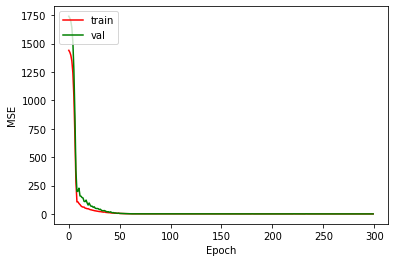

In [30]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_dlbinnedJla.png", dpi=200)

In [31]:
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet, np.min(model_train.history['loss']), np.min(model_train.history['val_loss'])

(0.1240279767564928, 0.158807173371315, 0.015382939018309116)

In [32]:
# pred = neural_model.predict(z_test)
# pred
np.min(z), np.max(z)

(0.01, 1.3)

In [33]:
# ranz = np.random.uniform(np.min(z), np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z), 31)
ranzz = scalerz.transform(ranz.reshape((-1,1)))

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model.predict(ranzz)
# pred_random

In [34]:
# recover z
# z = scalerz.inverse_transform(z)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [35]:
fake_encoded = np.zeros((1, 31))

In [36]:
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))
print(type(encoded_imgs))


(1, 31)
(31,)
(200, 31)
<class 'numpy.ndarray'>


In [37]:
for i, avg in enumerate(avg_encoded):
    alpha = avg/zz[i]
    fake_encoded[0, i] = alpha * ranzz[i]

In [38]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake), np.shape(fake_encoded)

((1, 961), (1, 31))

In [39]:
# decoded_fake[0, :]

9.2860137e-07

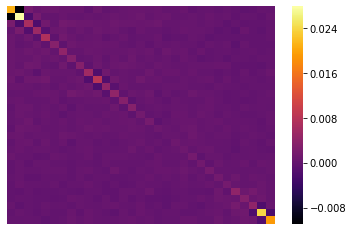

In [40]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

-0.01084098704 0.02815552265 0.00039265133851975654
-0.010891664 0.02781838 0.00038237876
-0.010769944 0.027781377 0.00038696537


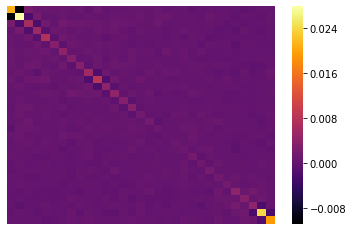

In [41]:
clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
sns.heatmap(pd.DataFrame(clean_img[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.savefig('fake_cov_clean_jla.png', dpi=200)
np.min(np.abs(clean_img[0, :]))

print(np.min(syscov), np.max(syscov), np.mean(syscov)) #checking non-negatives in the diagonal
print(np.min(decoded_fake[0,:]), np.max(decoded_fake[0,:]), np.mean(decoded_fake[0,:])) #checking non-negatives in the diagonal
print(np.min(clean_img[0,:]), np.max(clean_img[0,:]), np.mean(clean_img[0,:])) #checking non-negatives in the diagonal



In [42]:
# np.savetxt("fake_binned_JLA_COVdecoded.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
# np.savetxt("fake_binned_JLA_COVdecodedclean.dat", clean_img[0, :].reshape(31,31), delimiter= " ", header="#fake COV")

In [43]:
count = 0
new_cov =decoded_fake[0, :].reshape(31,31)

for i in range(len(new_cov)):
    for j in range(len(new_cov)):
        if np.iscomplex(new_cov[i,j]):
            print("COMPLEX")
        if new_cov[i,j] != new_cov[j,i]:
#             print(i,j, end=' ')
#             print(new_cov[i,j], new_cov[j,i]) 
            count+=1
            new_cov[j,i] = new_cov[i, j]

count

465

In [44]:
# np.savetxt("fake_binned_JLA_COVdecodedsim.dat", new_cov, delimiter= " ", header="#fake COV")

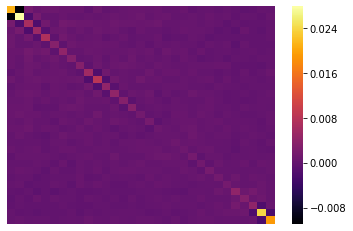

In [45]:
sns.heatmap(pd.DataFrame(new_cov), fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [46]:
fake_data = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)
# np.savetxt("fake_binned_JLA.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu")

In [47]:
errors = np.sqrt(np.abs(np.diagonal(syscov)))
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
np.max(errors), np.max(fakeerrors)

(0.1677960745965173, 0.16678843)

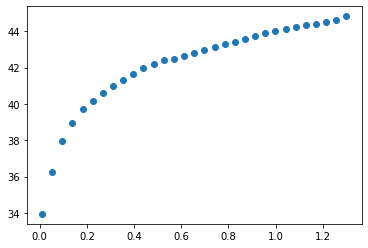

In [48]:
plt.scatter(ranz, pred_random)

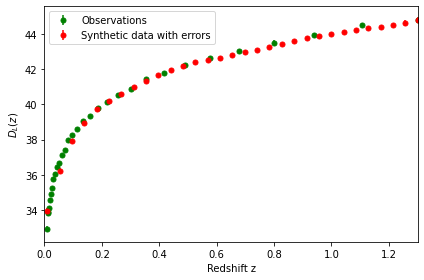

In [49]:
plt.errorbar(z, dl, yerr=errors, fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, pred_random, 
             yerr=fakeerrors, fmt='r.', markersize=10., label='Synthetic data with errors')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
plt.xlim(0, np.max(z))
plt.tight_layout()
plt.legend()
# plt.savefig('fake_vs_binned_jla.png', dpi=200)

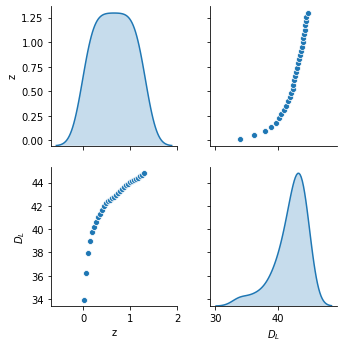

In [50]:
fake_datadf = pd.DataFrame(fake_data, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf, diag_kind="kde")
plt.savefig('fake_binned_jla.png')

In [51]:
# Guardar modelos
# autoencoder.save('autoencoderJLA.h5')
# decoder.save('decoderJLA.h5')
# encoder.save('encoderJLA.h5')
# neural_model.save('FFNN_JLA.h5')

# NOW we use dropout as uncertainty estimator

In [145]:
from astroNN.nn.layers import MCDropout

In [146]:
# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img2 = tf.keras.Input(shape=(31*31,))
# begin encoder
x2 = layers.Dense(100, activation='tanh')(input_img2)
x2 = MCDropout(0.1)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
encoded2 = layers.Dense(encoding_dim, activation='tanh')(x2)
x2 = MCDropout(0.1)(encoded2)
#begin decoder
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
decoded2 = layers.Dense(31*31, activation='linear')(x2)


# This model maps an input to its reconstruction
autoencoder2 = tf.keras.Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder2.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 961)]             0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               96200     
_________________________________________________________________
MCDropout_19 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               10100     
_________________________________________________________________
MCDropout_20 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 31)                3131      
_________________________________________________________________
MCDropout_21 (MCDropout)     (None, 31)              

In [ ]:
# optimizer = Adam(lr=.005)
# optimizer = Adam(lr=0.0001)


autoencoder2_train = autoencoder2.fit(covset_noise_train, covset_train,
                    epochs=1200,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(covset_noise_test, covset_test))
#                     callbacks=callbacks)

Epoch 1/1200
25/25 [==============================] - 0s 14ms/step - loss: 3.3446e-06 - val_loss: 1.8710e-06
Epoch 2/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.6690e-06 - val_loss: 1.5575e-06
Epoch 3/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.5312e-06 - val_loss: 1.5404e-06
Epoch 4/1200
25/25 [==============================] - 0s 6ms/step - loss: 1.5412e-06 - val_loss: 1.5542e-06
Epoch 5/1200
25/25 [==============================] - 0s 7ms/step - loss: 1.5064e-06 - val_loss: 1.4811e-06
Epoch 6/1200
25/25 [==============================] - 0s 7ms/step - loss: 1.4849e-06 - val_loss: 1.5703e-06
Epoch 7/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.4848e-06 - val_loss: 1.4649e-06
Epoch 8/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.4475e-06 - val_loss: 1.4047e-06
Epoch 9/1200
25/25 [==============================] - 0s 6ms/step - loss: 1.4409e-06 - val_loss: 1.4990e-06
Epoch 10/1200
25/25 [======

25/25 [==============================] - 0s 7ms/step - loss: 1.1146e-06 - val_loss: 1.1390e-06
Epoch 77/1200
25/25 [==============================] - 0s 6ms/step - loss: 1.1140e-06 - val_loss: 1.1291e-06
Epoch 78/1200
25/25 [==============================] - 0s 6ms/step - loss: 1.1065e-06 - val_loss: 1.1361e-06
Epoch 79/1200
25/25 [==============================] - 0s 6ms/step - loss: 1.1143e-06 - val_loss: 1.1327e-06
Epoch 80/1200
25/25 [==============================] - 0s 7ms/step - loss: 1.1134e-06 - val_loss: 1.1360e-06
Epoch 81/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.1107e-06 - val_loss: 1.1300e-06
Epoch 82/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.1128e-06 - val_loss: 1.1350e-06
Epoch 83/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.1178e-06 - val_loss: 1.1366e-06
Epoch 84/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.1072e-06 - val_loss: 1.1241e-06
Epoch 85/1200
25/25 [============

Epoch 151/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0848e-06 - val_loss: 1.0943e-06
Epoch 152/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0842e-06 - val_loss: 1.1037e-06
Epoch 153/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0821e-06 - val_loss: 1.0999e-06
Epoch 154/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0862e-06 - val_loss: 1.1090e-06
Epoch 155/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0806e-06 - val_loss: 1.0964e-06
Epoch 156/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0792e-06 - val_loss: 1.0949e-06
Epoch 157/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0826e-06 - val_loss: 1.1028e-06
Epoch 158/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0837e-06 - val_loss: 1.0951e-06
Epoch 159/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0829e-06 - val_loss: 1.1073e-06
Epoch 160/

25/25 [==============================] - 0s 4ms/step - loss: 1.0723e-06 - val_loss: 1.0877e-06
Epoch 226/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0727e-06 - val_loss: 1.0903e-06
Epoch 227/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0733e-06 - val_loss: 1.0864e-06
Epoch 228/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0739e-06 - val_loss: 1.0819e-06
Epoch 229/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0723e-06 - val_loss: 1.0876e-06
Epoch 230/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0747e-06 - val_loss: 1.0886e-06
Epoch 231/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0755e-06 - val_loss: 1.0934e-06
Epoch 232/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0737e-06 - val_loss: 1.0946e-06
Epoch 233/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0719e-06 - val_loss: 1.0863e-06
Epoch 234/1200
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0663e-06 - val_loss: 1.0867e-06
Epoch 300/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.0691e-06 - val_loss: 1.0828e-06
Epoch 301/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0687e-06 - val_loss: 1.0779e-06
Epoch 302/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0635e-06 - val_loss: 1.0777e-06
Epoch 303/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.0655e-06 - val_loss: 1.0788e-06
Epoch 304/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0695e-06 - val_loss: 1.0857e-06
Epoch 305/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0687e-06 - val_loss: 1.0824e-06
Epoch 306/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.0647e-06 - val_loss: 1.0733e-06
Epoch 307/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.0661e-06 - val_loss: 1.0843e-06
Epoch 308/1200
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0643e-06 - val_loss: 1.0718e-06
Epoch 374/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0608e-06 - val_loss: 1.0760e-06
Epoch 375/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0607e-06 - val_loss: 1.0759e-06
Epoch 376/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0611e-06 - val_loss: 1.0803e-06
Epoch 377/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0625e-06 - val_loss: 1.0703e-06
Epoch 378/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0663e-06 - val_loss: 1.0833e-06
Epoch 379/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0636e-06 - val_loss: 1.0775e-06
Epoch 380/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.0629e-06 - val_loss: 1.0771e-06
Epoch 381/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0677e-06 - val_loss: 1.0756e-06
Epoch 382/1200
25/25 [===

25/25 [==============================] - 0s 9ms/step - loss: 1.0648e-06 - val_loss: 1.0704e-06
Epoch 448/1200
25/25 [==============================] - 0s 8ms/step - loss: 1.0617e-06 - val_loss: 1.0699e-06
Epoch 449/1200
25/25 [==============================] - 0s 8ms/step - loss: 1.0640e-06 - val_loss: 1.0789e-06
Epoch 450/1200
25/25 [==============================] - 0s 9ms/step - loss: 1.0626e-06 - val_loss: 1.0827e-06
Epoch 451/1200
25/25 [==============================] - 0s 9ms/step - loss: 1.0637e-06 - val_loss: 1.0746e-06
Epoch 452/1200
25/25 [==============================] - 0s 8ms/step - loss: 1.0639e-06 - val_loss: 1.0856e-06
Epoch 453/1200
25/25 [==============================] - 0s 8ms/step - loss: 1.0676e-06 - val_loss: 1.0698e-06
Epoch 454/1200
25/25 [==============================] - 0s 9ms/step - loss: 1.0653e-06 - val_loss: 1.0761e-06
Epoch 455/1200
25/25 [==============================] - 0s 7ms/step - loss: 1.0632e-06 - val_loss: 1.0783e-06
Epoch 456/1200
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0636e-06 - val_loss: 1.0854e-06
Epoch 522/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0634e-06 - val_loss: 1.0775e-06
Epoch 523/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0633e-06 - val_loss: 1.0887e-06
Epoch 524/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0626e-06 - val_loss: 1.0687e-06
Epoch 525/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0576e-06 - val_loss: 1.0694e-06
Epoch 526/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0596e-06 - val_loss: 1.0719e-06
Epoch 527/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0602e-06 - val_loss: 1.0674e-06
Epoch 528/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0592e-06 - val_loss: 1.0728e-06
Epoch 529/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0640e-06 - val_loss: 1.0777e-06
Epoch 530/1200
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0616e-06 - val_loss: 1.0758e-06
Epoch 596/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0575e-06 - val_loss: 1.0714e-06
Epoch 597/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0612e-06 - val_loss: 1.0795e-06
Epoch 598/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0616e-06 - val_loss: 1.0683e-06
Epoch 599/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0581e-06 - val_loss: 1.0711e-06
Epoch 600/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0609e-06 - val_loss: 1.0755e-06
Epoch 601/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0621e-06 - val_loss: 1.0825e-06
Epoch 602/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0604e-06 - val_loss: 1.0752e-06
Epoch 603/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0600e-06 - val_loss: 1.0747e-06
Epoch 604/1200
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0603e-06 - val_loss: 1.0686e-06
Epoch 670/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0595e-06 - val_loss: 1.0688e-06
Epoch 671/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0600e-06 - val_loss: 1.0706e-06
Epoch 672/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0564e-06 - val_loss: 1.0772e-06
Epoch 673/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0601e-06 - val_loss: 1.0716e-06
Epoch 674/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0597e-06 - val_loss: 1.0709e-06
Epoch 675/1200
25/25 [==============================] - 0s 3ms/step - loss: 1.0590e-06 - val_loss: 1.0794e-06
Epoch 676/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0624e-06 - val_loss: 1.0692e-06
Epoch 677/1200
25/25 [==============================] - 0s 3ms/step - loss: 1.0573e-06 - val_loss: 1.0734e-06
Epoch 678/1200
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0580e-06 - val_loss: 1.0732e-06
Epoch 744/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0591e-06 - val_loss: 1.0693e-06
Epoch 745/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0551e-06 - val_loss: 1.0598e-06
Epoch 746/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0563e-06 - val_loss: 1.0717e-06
Epoch 747/1200
25/25 [==============================] - 0s 3ms/step - loss: 1.0555e-06 - val_loss: 1.0633e-06
Epoch 748/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0563e-06 - val_loss: 1.0708e-06
Epoch 749/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0556e-06 - val_loss: 1.0679e-06
Epoch 750/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0576e-06 - val_loss: 1.0706e-06
Epoch 751/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0574e-06 - val_loss: 1.0810e-06
Epoch 752/1200
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0552e-06 - val_loss: 1.0695e-06
Epoch 818/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0580e-06 - val_loss: 1.0752e-06
Epoch 819/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0561e-06 - val_loss: 1.0694e-06
Epoch 820/1200
25/25 [==============================] - 0s 3ms/step - loss: 1.0568e-06 - val_loss: 1.0755e-06
Epoch 821/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0549e-06 - val_loss: 1.0757e-06
Epoch 822/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0562e-06 - val_loss: 1.0747e-06
Epoch 823/1200
25/25 [==============================] - 0s 3ms/step - loss: 1.0550e-06 - val_loss: 1.0692e-06
Epoch 824/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0579e-06 - val_loss: 1.0714e-06
Epoch 825/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0574e-06 - val_loss: 1.0709e-06
Epoch 826/1200
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0561e-06 - val_loss: 1.0688e-06
Epoch 892/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0556e-06 - val_loss: 1.0720e-06
Epoch 893/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0543e-06 - val_loss: 1.0718e-06
Epoch 894/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0544e-06 - val_loss: 1.0751e-06
Epoch 895/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.0560e-06 - val_loss: 1.0684e-06
Epoch 896/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0570e-06 - val_loss: 1.0675e-06
Epoch 897/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0543e-06 - val_loss: 1.0702e-06
Epoch 898/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0549e-06 - val_loss: 1.0631e-06
Epoch 899/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0542e-06 - val_loss: 1.0671e-06
Epoch 900/1200
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0514e-06 - val_loss: 1.0637e-06
Epoch 966/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0523e-06 - val_loss: 1.0727e-06
Epoch 967/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0599e-06 - val_loss: 1.0751e-06
Epoch 968/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0579e-06 - val_loss: 1.0804e-06
Epoch 969/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0580e-06 - val_loss: 1.0698e-06
Epoch 970/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0558e-06 - val_loss: 1.0681e-06
Epoch 971/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0569e-06 - val_loss: 1.0701e-06
Epoch 972/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0570e-06 - val_loss: 1.0718e-06
Epoch 973/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.0550e-06 - val_loss: 1.0670e-06
Epoch 974/1200
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0529e-06 - val_loss: 1.0653e-06
Epoch 1040/1200
25/25 [==============================] - 0s 5ms/step - loss: 1.0498e-06 - val_loss: 1.0632e-06
Epoch 1041/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0524e-06 - val_loss: 1.0616e-06
Epoch 1042/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0516e-06 - val_loss: 1.0631e-06
Epoch 1043/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0555e-06 - val_loss: 1.0679e-06
Epoch 1044/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0547e-06 - val_loss: 1.0716e-06
Epoch 1045/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0545e-06 - val_loss: 1.0649e-06
Epoch 1046/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0517e-06 - val_loss: 1.0658e-06
Epoch 1047/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0564e-06 - val_loss: 1.0726e-06
Epoch 1048/1200
2

Epoch 1113/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0543e-06 - val_loss: 1.0682e-06
Epoch 1114/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0537e-06 - val_loss: 1.0667e-06
Epoch 1115/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0551e-06 - val_loss: 1.0691e-06
Epoch 1116/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0517e-06 - val_loss: 1.0667e-06
Epoch 1117/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0545e-06 - val_loss: 1.0613e-06
Epoch 1118/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0508e-06 - val_loss: 1.0644e-06
Epoch 1119/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0507e-06 - val_loss: 1.0691e-06
Epoch 1120/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0547e-06 - val_loss: 1.0727e-06
Epoch 1121/1200
25/25 [==============================] - 0s 4ms/step - loss: 1.0564e-06 - val_loss: 1.0671e-06
E

In [ ]:
plt.plot(autoencoder2_train.history['loss'], color='r', )
plt.plot(autoencoder2_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLAdropout.png', dpi=200)

In [ ]:
encoder2 = tf.keras.Model(input_img2, encoded2)
# This is our encoded (32-dimensional) input
encoded2_input = tf.keras.Input(shape=(encoding_dim,))

decoder2_layer1 = autoencoder2.layers[-5]
decoder2_layer2 = autoencoder2.layers[-4]
decoder2_layer3 = autoencoder2.layers[-3]
decoder2_layer4 = autoencoder2.layers[-2]
decoder2_layer5 = autoencoder2.layers[-1]

# create the decoder model
decoder2 = Model(encoded2_input, 
                decoder2_layer5(decoder2_layer4(decoder2_layer3(decoder2_layer2(decoder2_layer1(encoded2_input))))))

In [ ]:
decoder2.summary()

In [ ]:
# Generate test data
test_batch_size = 31*31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0, 2., test_batch_size)
print(np.shape(fake_encoded))
mc_dropout_num = 100  # Run Dropout 100 times
predictions_dec = np.zeros((mc_dropout_num, 1, test_batch_size))
uncertainty = np.zeros((mc_dropout_num, 1, test_batch_size))
for i in range(mc_dropout_num):
    predictions_dec[i] = decoder2.predict(fake_encoded)
    
# get mean results and its varience
prediction_mc_dropout_dec = np.mean(predictions_dec, axis=0, dtype=np.float64)
std_mc_dropout_dec = np.std(predictions_dec, axis=0, dtype=np.float64)
np.shape(prediction_mc_dropout_dec), np.shape(std_mc_dropout_dec)

In [ ]:
sns.heatmap(pd.DataFrame(prediction_mc_dropout_dec[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [ ]:
np.mean(std_mc_dropout_dec), np.shape(std_mc_dropout_dec)

In [ ]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.1)(efirst)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.1)(x)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.1)(x)
    x = Dense(30, activation='relu')(x)
    x = MCDropout(0.1)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

In [ ]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=2,
                                    epochs=800,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

In [ ]:
# Generate test data
# test_batch_size = 31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0.01, np.max(z), test_batch_size)
# Generate test data
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)

In [ ]:
plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_dropoutJLA.png', dpi=100)

In [ ]:
np.mean(std_mc_dropout)

In [ ]:
Om = 0.27
# variance network
w0 = -1

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, model, w0, wa):
        if model == 'lcdm':
            return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
        elif model == 'owacdm':
            return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, model, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(model, w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, model='lcdm', w0=-1, wa=0.5):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, model, w0, wa)*(1+z))+43

In [ ]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz))
#     fowacdm1.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.5))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

In [ ]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)

fakeerrors2 = np.sqrt(np.abs(np.diagonal(prediction_mc_dropout_dec .reshape(31,31))))

# std_dropout_diag = np.sqrt(np.abs(np.diagonal(std_mc_dropout_dec.reshape(31,31))))
std_dropout_diag = np.diagonal(std_mc_dropout_dec.reshape(31,31))

# sigma = np.sqrt(std_mc_dropout.reshape(31,) + fakeerrors2 + std_dropout_diag)
sigma = np.sqrt(std_mc_dropout.reshape(31,) + fakeerrors2 **2 + std_dropout_diag)

plt.errorbar(ranz, prediction_mc_dropout, yerr=sigma
             , markersize=10, fmt='.', 
             ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='b',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='r')
# plt.plot(zmodel, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0, np.max(z)+0.05)
plt.xlabel('Redshift')
plt.ylabel('$D_L(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('DL_dropout5.png', dpi=200)

In [ ]:
matrix_with_all_err = prediction_mc_dropout_dec[0, :].reshape(31,31)
np.fill_diagonal(matrix_with_all_err, sigma**2)

In [ ]:
np.savetxt("fake_binned_JLA_COVdecodedDO.dat", matrix_with_all_err, delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

In [ ]:
fake_datadf2 = pd.DataFrame(fake_data2, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf2, diag_kind="kde")
plt.savefig('fake_binned_jla22DO.png')

In [ ]:
clean_img = autoencoder2.predict(matrix_with_all_err.reshape(1,31*31))
# prediction_mc_dropout_dec[0, :].reshape(31,31)

In [ ]:
np.savetxt("fake_binned_JLA_COVdecodedDOclean.dat", clean_img.reshape(31,31), delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
# np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

In [ ]:
sns.heatmap(pd.DataFrame(clean_img.reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [ ]:
clean_img = autoencoder2.predict(clean_img)


In [ ]:
# prediction_mc_dropout_dec[0, :].reshape(31,31)
np.savetxt("fake_binned_JLA_COVdecodedDOclean2.dat", clean_img.reshape(31,31), delimiter= " ", header="#fake COV")

In [ ]:
sns.heatmap(pd.DataFrame(clean_img.reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [ ]:
autoencoder2.save('autoencoderJLA_DO.h5')
decoder2.save('decoderJLA_DO.h5')
neural_model2.save('FFNN_JLA_DO.h5')
encoder2.save('encoderJLA_DO.h5')

In [ ]:
count = 0
new_cov = matrix_with_all_err

for i in range(len(new_cov)):
    for j in range(len(new_cov)):
        if np.iscomplex(new_cov[i,j]):
            print("COMPLEX")
        if new_cov[i,j] != new_cov[j,i]:
#             print(i,j, end=' ')
#             print(new_cov[i,j], new_cov[j,i]) 
            count+=1
            new_cov[j,i] = new_cov[i, j]

count

In [ ]:
np.savetxt("fake_binned_JLA_COVdecodedDOsim.dat", new_cov, delimiter= " ", header="#fake COV")